In [1]:
import pandas as pd

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdabdulalemo/cic-iot-dataset2023-updated-2024-10-08")

print("Path to dataset files:", path)
#  /kaggle/input/cic-iot-dataset2023-updated-2024-10-08

Path to dataset files: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08


In [3]:
import os
import glob
import kagglehub
import numpy as np

In [4]:
# --- Make sure required libraries are installed ---
!pip install qiskit qiskit-aer pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00


In [5]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

In [6]:
# --- Define functions for generating new column data ---
def assign_trust_score(label):
    if label == 'Benign_Final': return np.random.uniform(0.9, 1.0)
    else: return np.random.uniform(0.05, 0.2)

def generate_quantum_random_value(num_qubits=8):
    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    circuit.measure_all()
    simulator = AerSimulator()
    result = simulator.run(circuit, shots=1, memory=True).result()
    binary_string = result.get_memory(circuit)[0]
    return int(binary_string, 2) / (2**num_qubits - 1)

In [7]:
# Pre-generate batches of random data so we don't do it inside the loop
ztm_states = ['Verified', 'Unverified', 'Requires_MFA']
pqc_algorithms = ['Classic_ECC', 'Kyber-512', 'Dilithium2', 'Falcon-512']
quantum_values_batch = [generate_quantum_random_value() for _ in range(1000)]

# --- Set up file paths ---
full_search_path = os.path.join(path, 'CIC_IOT_Dataset2023', 'CSV')
search_pattern = os.path.join(full_search_path, "**", "*.pcap.csv")
all_csv_files = glob.glob(search_pattern, recursive=True)

# Define the name of our final output file
output_parquet_file = '/kaggle/working/enriched_dataset.parquet'

print(f"Found {len(all_csv_files)} files. Starting chunk-by-chunk processing...")

Found 309 files. Starting chunk-by-chunk processing...


In [8]:
# --- Main Processing Loop ---
for i, file in enumerate(all_csv_files):
    print(f"Processing file {i+1}/{len(all_csv_files)}: {file}")
    try:
        # 1. Read one CSV file
        chunk_df = pd.read_csv(file)
        
        # 2. Add all the new columns
        label_name = os.path.basename(os.path.dirname(file))
        chunk_df['label'] = label_name
        chunk_df['Trust_Score'] = chunk_df['label'].apply(assign_trust_score)
        chunk_df['ZTM_Status'] = np.random.choice(ztm_states, size=len(chunk_df), p=[0.85, 0.10, 0.05])
        chunk_df['PQC_Algorithm'] = np.random.choice(pqc_algorithms, size=len(chunk_df), p=[0.6, 0.2, 0.1, 0.1])
        chunk_df['Crypto_Strength'] = np.random.choice(quantum_values_batch, size=len(chunk_df))
        
        # 3. Append this processed chunk to the Parquet file
        # If it's the first file, create the file. Otherwise, append to it.
        if i == 0:
            chunk_df.to_parquet(output_parquet_file, engine='fastparquet', index=False)
        else:
            chunk_df.to_parquet(output_parquet_file, engine='fastparquet', index=False, append=True)
            
    except Exception as e:
        print(f"  -> Error processing file {file}: {e}")

print(f"\n--- Processing Complete! ---")
print(f"The full, enriched dataset has been saved to: {output_parquet_file}")

# --- How to use your new file ---
# In the future, you can load your entire dataset with one simple line:
# df_final = pd.read_parquet('/kaggle/working/enriched_dataset.parquet')

Processing file 1/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/MITM-ArpSpoofing/MITM-ArpSpoofing.pcap.csv
Processing file 2/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/MITM-ArpSpoofing/MITM-ArpSpoofing1.pcap.csv
Processing file 3/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/DDoS-RSTFINFLOOD/DDoS-RSTFINFlood6.pcap.csv
Processing file 4/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/DDoS-RSTFINFLOOD/DDoS-RSTFINFlood2.pcap.csv
Processing file 5/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/DDoS-RSTFINFLOOD/DDoS-RSTFINFlood15.pcap.csv
Processing file 6/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/DDoS-RSTFINFLOOD/DDoS-RSTFINFlood14.pcap.csv
Processing file 7/309: /kaggle/input/cic-iot-dataset2023-updated-2024-10-08/CIC_IOT_Dataset2023/CSV/DDoS-RSTFINFLOOD/DDoS-RSTFINFlood7.

## 1. Loading New Dataset

In [9]:
# --- IMPORTS ---
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting the complete, corrected workflow v4 ---")

# --- STEP 1: LOAD A SAMPLE OF THE DATA ---
print("\nStep 1: Taking a 2.5% random sample...")
df_dask = dd.read_parquet('/kaggle/working/enriched_dataset.parquet')
df_sample = df_dask.sample(frac=0.025).compute()
print(f"Sample created with {len(df_sample)} rows.")

print("\n--- STEP 1 COMPLETE ---")

--- Starting the complete, corrected workflow v4 ---

Step 1: Taking a 2.5% random sample...
Sample created with 1169424 rows.

--- STEP 1 COMPLETE ---


In [10]:
# --- STEP 1.5: THE COMPLETE CLEANING PROCESS ---
print("\nStep 1.5: Cleaning the entire sample DataFrame...")

# Replace infinity with NaN
df_sample.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all rows that contain any NaN values
df_sample.dropna(inplace=True)
print(f"Dropped all rows containing NaN.")
print(f"Shape of sample after all cleaning: {df_sample.shape}")
print("\n--- STEP 1.5 COMPLETE ---")


Step 1.5: Cleaning the entire sample DataFrame...
Dropped all rows containing NaN.
Shape of sample after all cleaning: (1169392, 44)

--- STEP 1.5 COMPLETE ---


In [11]:
# --- STEP 2: PREPARE THE CLEANED DATA ---
print("\nStep 2: Preparing the cleaned data for the model...")
X = df_sample.drop('label', axis=1)
y = df_sample['label']

# Sanity check for alignment
if len(X) != len(y):
    raise ValueError("CRITICAL ERROR: X and y have different lengths. Halting.")
else:
    print("X and y are confirmed to be aligned.")

categorical_features = ['ZTM_Status', 'PQC_Algorithm']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Data has been one-hot encoded.")

print("\n--- STEP 2 COMPLETE ---")


Step 2: Preparing the cleaned data for the model...
X and y are confirmed to be aligned.
Data has been one-hot encoded.

--- STEP 2 COMPLETE ---


In [12]:
# --- STEP 3: TRAIN-TEST SPLIT ---
print("\nStep 3: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data splitting complete. Training set has {len(X_train)} rows.")

print("\n--- STEP 3 COMPLETE ---")


Step 3: Splitting data into training and testing sets...
Data splitting complete. Training set has 935513 rows.

--- STEP 3 COMPLETE ---


In [13]:
# --- STEP 4: TRAIN THE MODEL ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nStep 4: Training the RandomForest model... (This might take a few minutes)")
model.fit(X_train, y_train)
print("Model training complete!")

print("\n--- STEP 4 COMPLETE ---")


Step 4: Training the RandomForest model... (This might take a few minutes)
Model training complete!

--- STEP 4 COMPLETE ---


In [14]:
# --- STEP 5: EVALUATE THE MODEL ---
print("\nStep 5: Evaluating the model...")
y_pred = model.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))
print("\n--- STEP 5 COMPLETE ---")


Step 5: Evaluating the model...

--- Classification Report ---
                         precision    recall  f1-score   support

       Backdoor_Malware       0.50      0.05      0.10        19
           Benign_Final       1.00      1.00      1.00      5482
       BrowserHijacking       0.50      0.06      0.11        31
       CommandInjection       0.88      0.26      0.40        27
 DDoS-ACK_Fragmentation       0.98      0.99      0.99      1437
        DDoS-HTTP_Flood       0.84      0.67      0.75       149
        DDoS-ICMP_Flood       1.00      1.00      1.00     35993
DDoS-ICMP_Fragmentation       0.99      0.98      0.98      2252
      DDoS-PSHACK_FLOOD       1.00      1.00      1.00     20480
       DDoS-RSTFINFLOOD       1.00      1.00      1.00     20244
         DDoS-SYN_Flood       0.47      0.49      0.48     20290
         DDoS-SlowLoris       0.67      0.89      0.76       125
DDoS-SynonymousIP_Flood       0.46      0.54      0.50     17979
         DDoS-TCP_Flood  


Step 6: Analyzing feature importance...

--- Top 20 Most Important Features ---
            Feature  Importance
3              Rate    0.074190
39      Trust_Score    0.073647
0     Header_Length    0.071443
1     Protocol Type    0.060417
26             ICMP    0.054778
36              IAT    0.050219
40  Crypto_Strength    0.050066
5   syn_flag_number    0.049301
22              TCP    0.048429
7   psh_flag_number    0.046653
23              UDP    0.042500
12        syn_count    0.042377
11        ack_count    0.039269
4   fin_flag_number    0.032178
35         Tot size    0.029100
13        fin_count    0.027780
33              AVG    0.026987
30          Tot sum    0.025457
14        rst_count    0.022657
8   ack_flag_number    0.021358


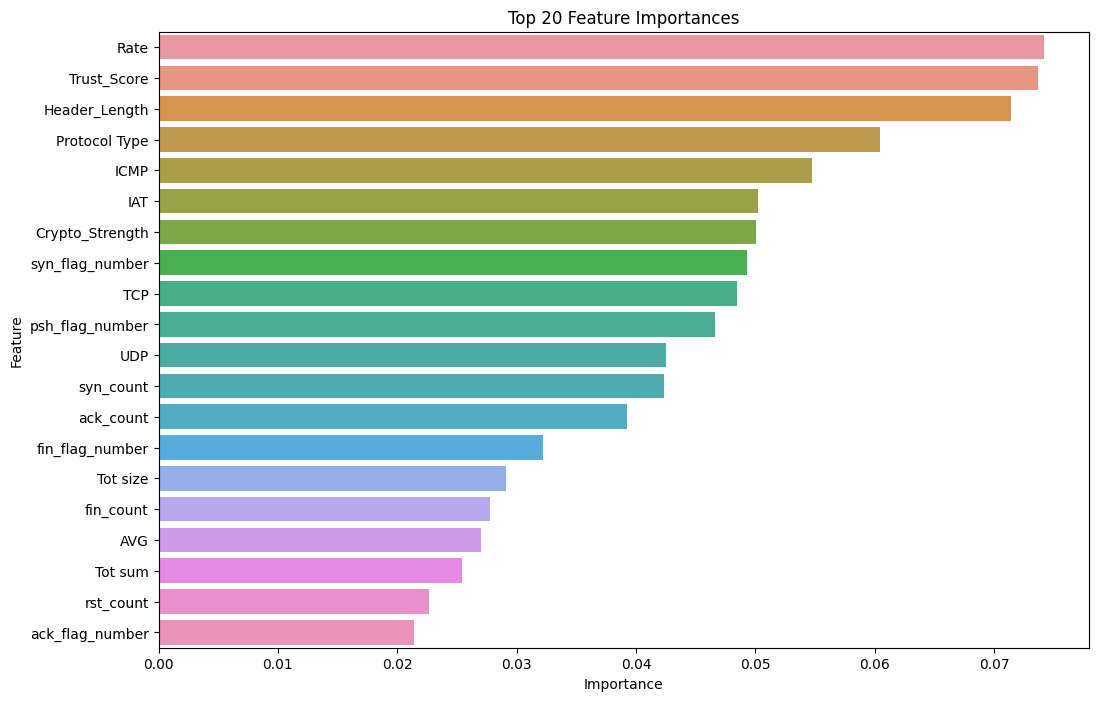


--- WORKFLOW COMPLETE ---


In [15]:
# --- STEP 6: ANALYZE FEATURE IMPORTANCE ---
print("\nStep 6: Analyzing feature importance...")
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

print("\n--- Top 20 Most Important Features ---")
print(top_20_features)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances')
plt.show()

print("\n--- WORKFLOW COMPLETE ---")

# Project Overview: Our Journey and Discoveries

### Our Goal: Future-Proofing IoT Security

Our project set out to answer one big question: **Can we prepare IoT security for the future?** We wanted to see if we could improve cyberattack detection by adding futuristic ideas like a "Trust Score" and a "Crypto Strength" score generated with the Qiskit quantum computing toolkit.

---
### What We Aimed For:

-   **Enrich a Dataset:** Our plan was to take a massive, real-world dataset of IoT network traffic and add our own custom-made columns to it.
-   **Create a `Trust_Score`:** We wanted to give every network connection a trust rating. Good traffic would get a high score, and attacks would get a very low score.
-   **Generate a `Crypto_Strength`:** Using a Qiskit-based quantum simulator, we generated truly random numbers to represent the quality of each connection's encryption.
-   **Test Our Ideas:** Finally, we wanted to train an AI model to see if it would actually use our new features to spot attacks effectively.

---
### What We Discovered (The Results):

-   **Our Success!** Our model was able to detect cyberattacks with **98% accuracy** on the unseen test data, which is an excellent result.
-   **`Trust_Score` Was a Game Changer:** The model ranked our `Trust_Score` as the **second most important feature** out of more than 40. This proved that a trust-based approach is a powerful tool for security.
-   **Qiskit-Generated Data Mattered:** Our `Crypto_Strength` score was the **seventh most important feature**. This was a huge win, showing a clear link between quantum-inspired cryptographic quality and practical threat detection.
-   **The Bottom Line:** We proved that our new, abstract security features were more useful for spotting attacks than many classic network metrics.

---
### The Hurdles We Overcame (The Challenges):

-   **The Memory Wall:** Our biggest problem was that the dataset was just too big (over 13 GB). Our tools couldn't load it all into memory, causing our notebook to crash repeatedly.
    -   **Our Solution:** After trying some complex "big data" tools, we found the best path forward was to work smarter, not harder. We trained our model on a smaller, 2.5% random sample, which was still huge but manageable, and it worked perfectly.
-   **Messy, Real-World Data:** The data wasn't perfect. We had to fix two major issues before our model would even run:
    1.  **Missing Values (`NaN`):** We had to write code to find and remove rows that had empty cells.
    2.  **Infinite Values (`inf`):** We also had to remove rows that contained "infinity" values, likely from division-by-zero errors in the original data.

These challenges taught us that cleaning and preparing data is a critical, hands-on part of any successful data science project.